In [2]:
import numpy as np
import matplotlib.pyplot as plt
from models import StochasticVolatilityModel, generate_data
from filters import ExactDaumHuangFlow, LocalExactDaumHuangFlow


In [3]:
# Stochastic Volatility Model
# State: x (log-volatility, 1D)
# Observation: y (returns, 1D)
# Nonlinear observation: y = β·exp(x/2)·v

# Model parameters
alpha = 0.91
sigma = 1.0
beta = 0.5

# Create model and generate data
random_state = np.random.default_rng(42)
model_sv = StochasticVolatilityModel(alpha=alpha, sigma=sigma, beta=beta, random_state=random_state)
T = 500
true_states_sv, observations_sv = generate_data(model_sv, T, random_state)

print(f"Generated {T} time steps")
print(f"State dimension: {model_sv.state_dim}, Observation dimension: {model_sv.obs_dim}")


Generated 500 time steps
State dimension: 1, Observation dimension: 1


In [4]:
# Run Exact Daum-Huang Flow Filter
print("Running ExactDaumHuangFlow...")
flow_exact = ExactDaumHuangFlow(
    model_sv, 
    n_particles=1000, 
    n_lambda_steps=100, 
    integration_method='euler'
)
flow_exact_means, flow_exact_covs = flow_exact.filter(observations_sv, random_state=random_state)
print("ExactDaumHuangFlow completed")


Running ExactDaumHuangFlow...
ExactDaumHuangFlow completed


In [6]:
# Run Local Exact Daum-Huang Flow Filter
print("Running LocalExactDaumHuangFlow...")
flow_local = LocalExactDaumHuangFlow(
    model_sv, 
    n_particles=200, 
    n_lambda_steps=100, 
    integration_method='euler',
    kernel_type='gaussian'
)
flow_local_means, flow_local_covs = flow_local.filter(observations_sv, random_state=random_state)
print("LocalExactDaumHuangFlow completed")


Running LocalExactDaumHuangFlow...
LocalExactDaumHuangFlow completed


In [7]:
# Compute errors for each filter
errors_exact = flow_exact_means - true_states_sv
errors_local = flow_local_means - true_states_sv

error_norms_exact = np.linalg.norm(errors_exact, axis=1)
error_norms_local = np.linalg.norm(errors_local, axis=1)

uncertainty_norms_exact = np.sqrt(np.trace(flow_exact_covs, axis1=1, axis2=2))
uncertainty_norms_local = np.sqrt(np.trace(flow_local_covs, axis1=1, axis2=2))

normalized_errors_exact = error_norms_exact / uncertainty_norms_exact
normalized_errors_local = error_norms_local / uncertainty_norms_local

# Summary statistics
print("\nSummary Statistics:")
print(f"Exact Flow - Mean error norm: {np.mean(error_norms_exact):.4f}, Std: {np.std(error_norms_exact):.4f}")
print(f"Exact Flow - Mean normalized error: {np.mean(normalized_errors_exact):.4f}, Max: {np.max(normalized_errors_exact):.4f}")
print(f"Local Flow - Mean error norm: {np.mean(error_norms_local):.4f}, Std: {np.std(error_norms_local):.4f}")
print(f"Local Flow - Mean normalized error: {np.mean(normalized_errors_local):.4f}, Max: {np.max(normalized_errors_local):.4f}")



Summary Statistics:
Exact Flow - Mean error norm: 1.7768, Std: 1.3088
Exact Flow - Mean normalized error: 0.7386, Max: 2.9812
Local Flow - Mean error norm: 1.8123, Std: 1.3271
Local Flow - Mean normalized error: 0.7634, Max: 3.5512


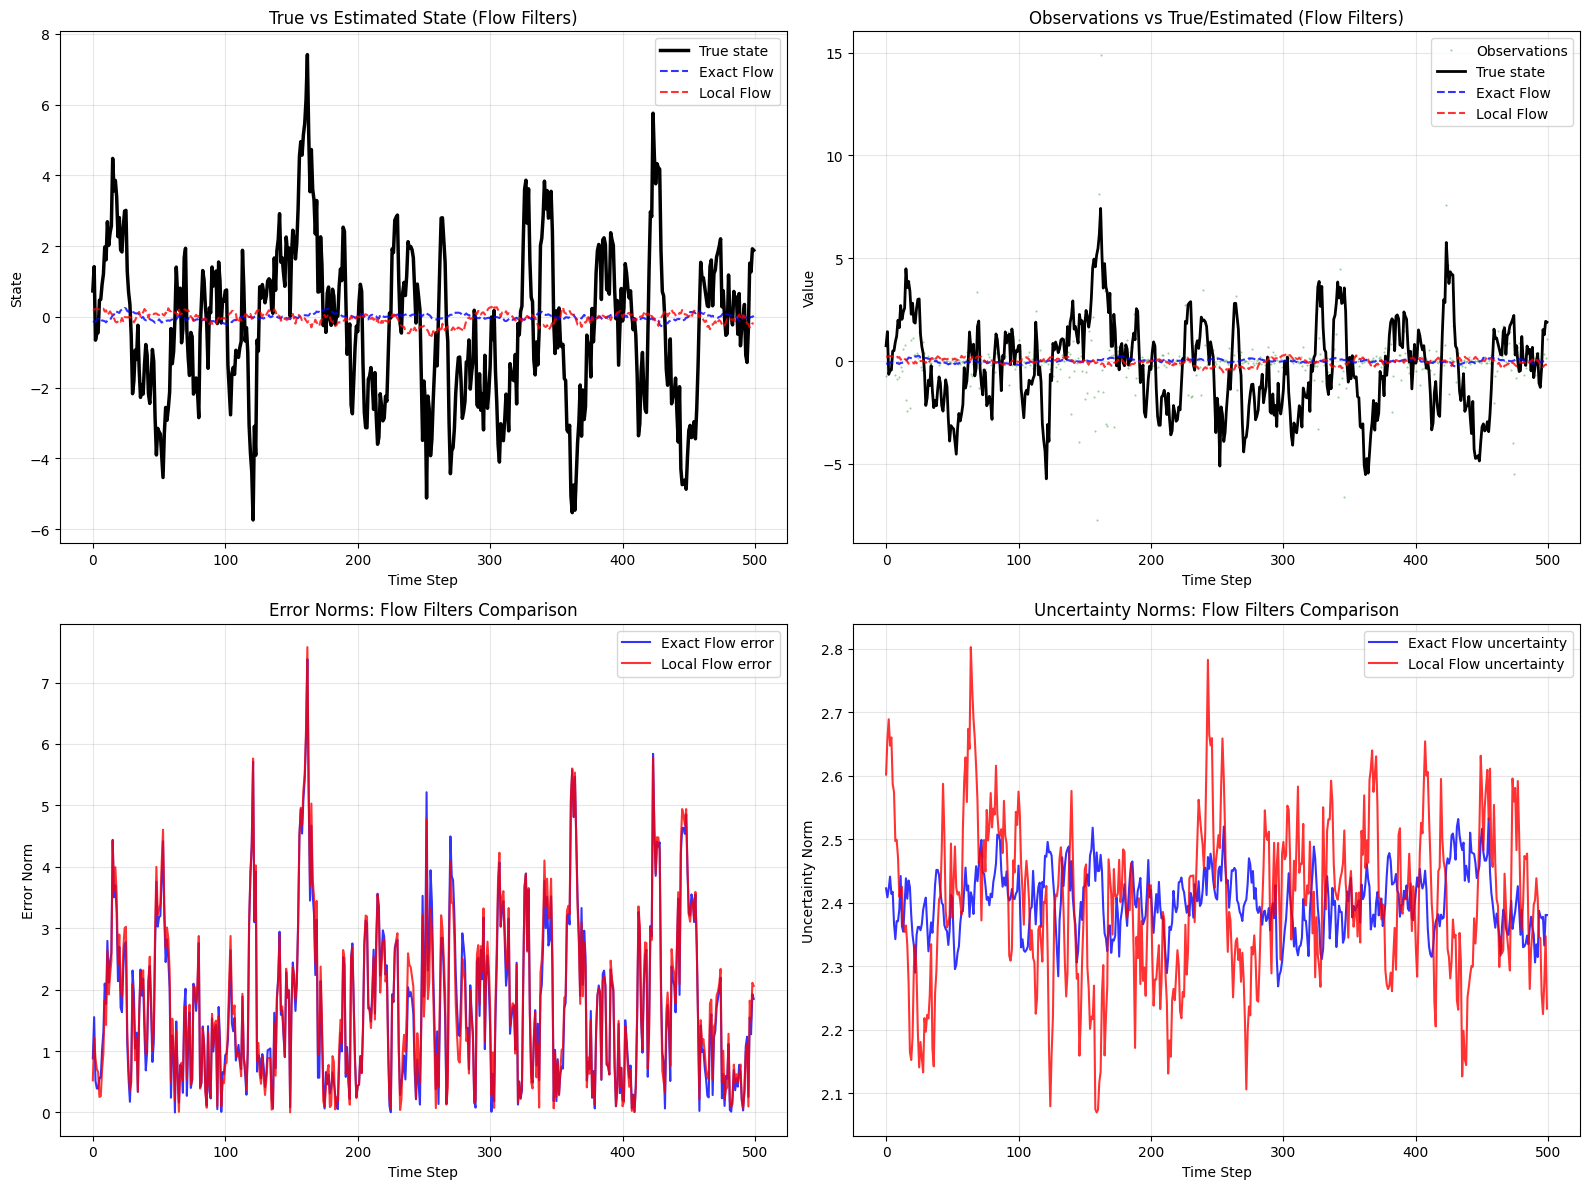

In [8]:
# Visualization: Compare both flow filters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
time_steps = np.arange(T)

# Plot 1: True vs Estimated (both filters)
ax = axes[0, 0]
ax.plot(time_steps, true_states_sv[:, 0], 'k-', label='True state', linewidth=2.5)
ax.plot(time_steps, flow_exact_means[:, 0], 'b--', label='Exact Flow', linewidth=1.5, alpha=0.8)
ax.plot(time_steps, flow_local_means[:, 0], 'r--', label='Local Flow', linewidth=1.5, alpha=0.8)
ax.set_xlabel('Time Step')
ax.set_ylabel('State')
ax.set_title('True vs Estimated State (Flow Filters)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Observations vs True/Estimated
ax = axes[0, 1]
ax.plot(time_steps, observations_sv[:, 0], 'g.', label='Observations', markersize=1, alpha=0.4)
ax.plot(time_steps, true_states_sv[:, 0], 'k-', label='True state', linewidth=2)
ax.plot(time_steps, flow_exact_means[:, 0], 'b--', label='Exact Flow', linewidth=1.5, alpha=0.8)
ax.plot(time_steps, flow_local_means[:, 0], 'r--', label='Local Flow', linewidth=1.5, alpha=0.8)
ax.set_xlabel('Time Step')
ax.set_ylabel('Value')
ax.set_title('Observations vs True/Estimated (Flow Filters)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Error norms (both filters)
ax = axes[1, 0]
ax.plot(time_steps, error_norms_exact, 'b-', linewidth=1.5, label='Exact Flow error', alpha=0.8)
ax.plot(time_steps, error_norms_local, 'r-', linewidth=1.5, label='Local Flow error', alpha=0.8)
ax.set_xlabel('Time Step')
ax.set_ylabel('Error Norm')
ax.set_title('Error Norms: Flow Filters Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Uncertainty norms (both filters)
ax = axes[1, 1]
ax.plot(time_steps, uncertainty_norms_exact, 'b-', linewidth=1.5, label='Exact Flow uncertainty', alpha=0.8)
ax.plot(time_steps, uncertainty_norms_local, 'r-', linewidth=1.5, label='Local Flow uncertainty', alpha=0.8)
ax.set_xlabel('Time Step')
ax.set_ylabel('Uncertainty Norm')
ax.set_title('Uncertainty Norms: Flow Filters Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


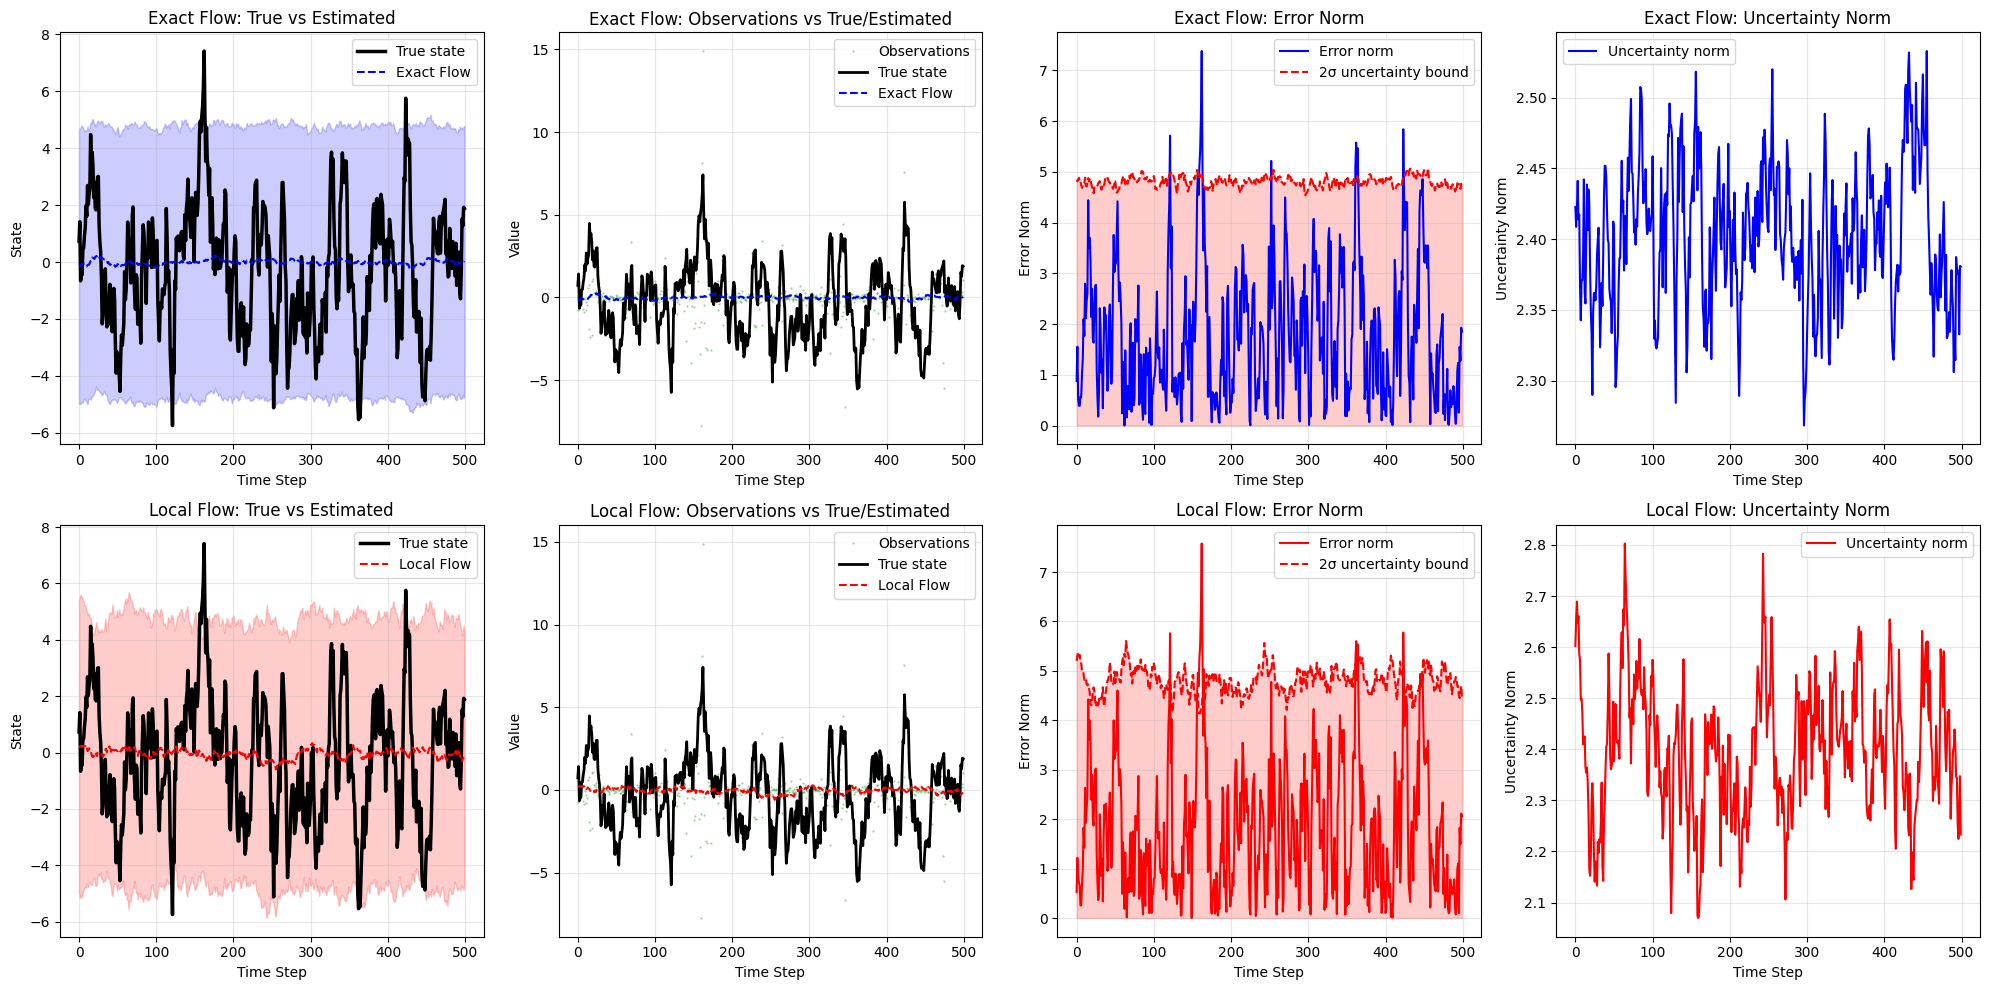

In [9]:
# Individual plots for each filter with 2σ confidence intervals
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
time_steps = np.arange(T)

# Compute standard deviations for each filter (1D state)
exact_std = np.sqrt(flow_exact_covs[:, 0, 0])
local_std = np.sqrt(flow_local_covs[:, 0, 0])

# Exact Flow plots
ax = axes[0, 0]
ax.plot(time_steps, true_states_sv[:, 0], 'k-', label='True state', linewidth=2.5)
ax.plot(time_steps, flow_exact_means[:, 0], 'b--', label='Exact Flow', linewidth=1.5)
ax.fill_between(time_steps, flow_exact_means[:, 0] - 2*exact_std, 
                flow_exact_means[:, 0] + 2*exact_std, alpha=0.2, color='blue')
ax.set_xlabel('Time Step')
ax.set_ylabel('State')
ax.set_title('Exact Flow: True vs Estimated')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.plot(time_steps, observations_sv[:, 0], 'g.', label='Observations', markersize=1, alpha=0.4)
ax.plot(time_steps, true_states_sv[:, 0], 'k-', label='True state', linewidth=2)
ax.plot(time_steps, flow_exact_means[:, 0], 'b--', label='Exact Flow', linewidth=1.5)
ax.set_xlabel('Time Step')
ax.set_ylabel('Value')
ax.set_title('Exact Flow: Observations vs True/Estimated')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 2]
ax.plot(time_steps, error_norms_exact, 'b-', linewidth=1.5, label='Error norm')
ax.plot(time_steps, 2*uncertainty_norms_exact, 'r--', linewidth=1.5, label='2σ uncertainty bound')
ax.fill_between(time_steps, np.zeros(T), 2*uncertainty_norms_exact, alpha=0.2, color='red')
ax.set_xlabel('Time Step')
ax.set_ylabel('Error Norm')
ax.set_title('Exact Flow: Error Norm')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 3]
ax.plot(time_steps, uncertainty_norms_exact, 'b-', linewidth=1.5, label='Uncertainty norm')
ax.set_xlabel('Time Step')
ax.set_ylabel('Uncertainty Norm')
ax.set_title('Exact Flow: Uncertainty Norm')
ax.legend()
ax.grid(True, alpha=0.3)

# Local Flow plots
ax = axes[1, 0]
ax.plot(time_steps, true_states_sv[:, 0], 'k-', label='True state', linewidth=2.5)
ax.plot(time_steps, flow_local_means[:, 0], 'r--', label='Local Flow', linewidth=1.5)
ax.fill_between(time_steps, flow_local_means[:, 0] - 2*local_std, 
                flow_local_means[:, 0] + 2*local_std, alpha=0.2, color='red')
ax.set_xlabel('Time Step')
ax.set_ylabel('State')
ax.set_title('Local Flow: True vs Estimated')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.plot(time_steps, observations_sv[:, 0], 'g.', label='Observations', markersize=1, alpha=0.4)
ax.plot(time_steps, true_states_sv[:, 0], 'k-', label='True state', linewidth=2)
ax.plot(time_steps, flow_local_means[:, 0], 'r--', label='Local Flow', linewidth=1.5)
ax.set_xlabel('Time Step')
ax.set_ylabel('Value')
ax.set_title('Local Flow: Observations vs True/Estimated')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 2]
ax.plot(time_steps, error_norms_local, 'r-', linewidth=1.5, label='Error norm')
ax.plot(time_steps, 2*uncertainty_norms_local, 'r--', linewidth=1.5, label='2σ uncertainty bound')
ax.fill_between(time_steps, np.zeros(T), 2*uncertainty_norms_local, alpha=0.2, color='red')
ax.set_xlabel('Time Step')
ax.set_ylabel('Error Norm')
ax.set_title('Local Flow: Error Norm')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 3]
ax.plot(time_steps, uncertainty_norms_local, 'r-', linewidth=1.5, label='Uncertainty norm')
ax.set_xlabel('Time Step')
ax.set_ylabel('Uncertainty Norm')
ax.set_title('Local Flow: Uncertainty Norm')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Compare flow diagnostics
exact_diagnostics = flow_exact.get_diagnostics()
local_diagnostics = flow_local.get_diagnostics()

# Plot flow convergence diagnostics
if exact_diagnostics['flow_diagnostics']:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot particle spread during flow (for first update step)
    if len(exact_diagnostics['flow_diagnostics']) > 0:
        exact_flow = exact_diagnostics['flow_diagnostics'][0]
        local_flow = local_diagnostics['flow_diagnostics'][0]
        
        ax = axes[0]
        if 'particle_spread' in exact_flow:
            ax.plot(exact_flow['particle_spread'], 'b-', label='Exact Flow', linewidth=1.5)
        if 'particle_spread' in local_flow:
            ax.plot(local_flow['particle_spread'], 'r-', label='Local Flow', linewidth=1.5)
        ax.set_xlabel('Flow Step (λ)')
        ax.set_ylabel('Particle Spread (std)')
        ax.set_title('Particle Spread During Flow (First Update)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        ax = axes[1]
        if 'mean_shift' in exact_flow:
            ax.plot(exact_flow['mean_shift'], 'b-', label='Exact Flow', linewidth=1.5)
        if 'mean_shift' in local_flow:
            ax.plot(local_flow['mean_shift'], 'r-', label='Local Flow', linewidth=1.5)
        ax.set_xlabel('Flow Step (λ)')
        ax.set_ylabel('Mean Shift Norm')
        ax.set_title('Mean Shift During Flow (First Update)')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


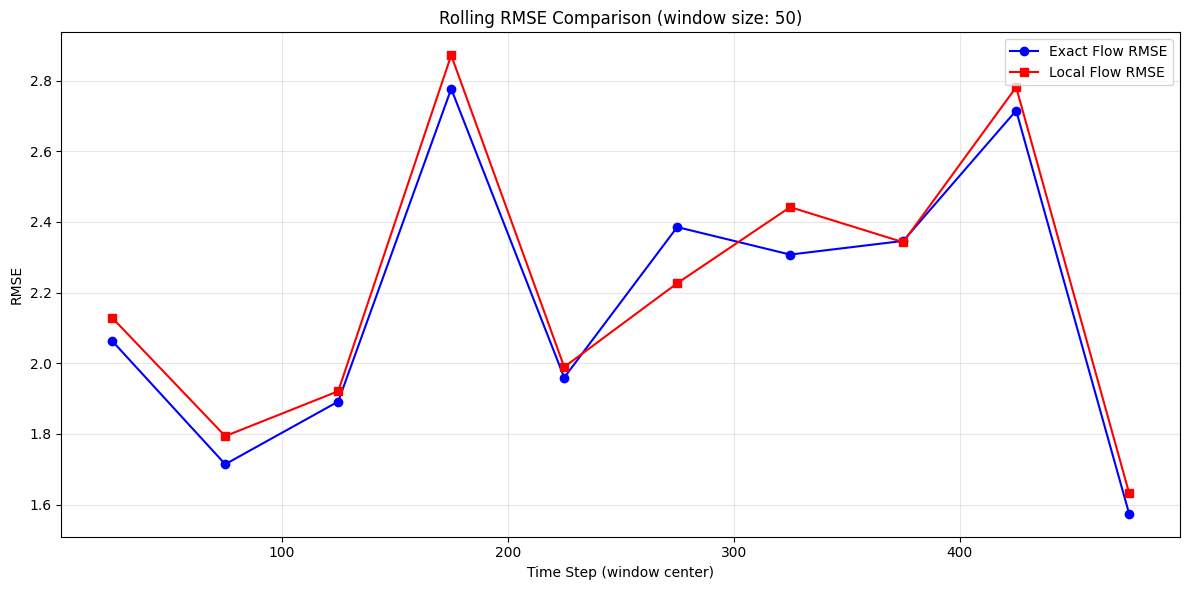


Overall RMSE:
Exact Flow: 2.2068
Local Flow: 2.2463


In [10]:
# Performance comparison: RMSE over time windows
window_size = 50
n_windows = T // window_size

exact_rmse_windows = []
local_rmse_windows = []

for i in range(n_windows):
    start_idx = i * window_size
    end_idx = (i + 1) * window_size
    
    exact_rmse = np.sqrt(np.mean(error_norms_exact[start_idx:end_idx]**2))
    local_rmse = np.sqrt(np.mean(error_norms_local[start_idx:end_idx]**2))
    
    exact_rmse_windows.append(exact_rmse)
    local_rmse_windows.append(local_rmse)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
window_centers = np.arange(n_windows) * window_size + window_size // 2
ax.plot(window_centers, exact_rmse_windows, 'b-o', label='Exact Flow RMSE', linewidth=1.5, markersize=6)
ax.plot(window_centers, local_rmse_windows, 'r-s', label='Local Flow RMSE', linewidth=1.5, markersize=6)
ax.set_xlabel('Time Step (window center)')
ax.set_ylabel('RMSE')
ax.set_title(f'Rolling RMSE Comparison (window size: {window_size})')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nOverall RMSE:")
print(f"Exact Flow: {np.sqrt(np.mean(error_norms_exact**2)):.4f}")
print(f"Local Flow: {np.sqrt(np.mean(error_norms_local**2)):.4f}")
